Loading results from: ./Res/ising_20250707_090222
Bootstrap results not found, skipping...
Loaded posterior samples shape: (10, 2000, 8)
Number of chains: 10
Number of samples per chain: 2000
Number of parameters: 8

Generating traceplots...


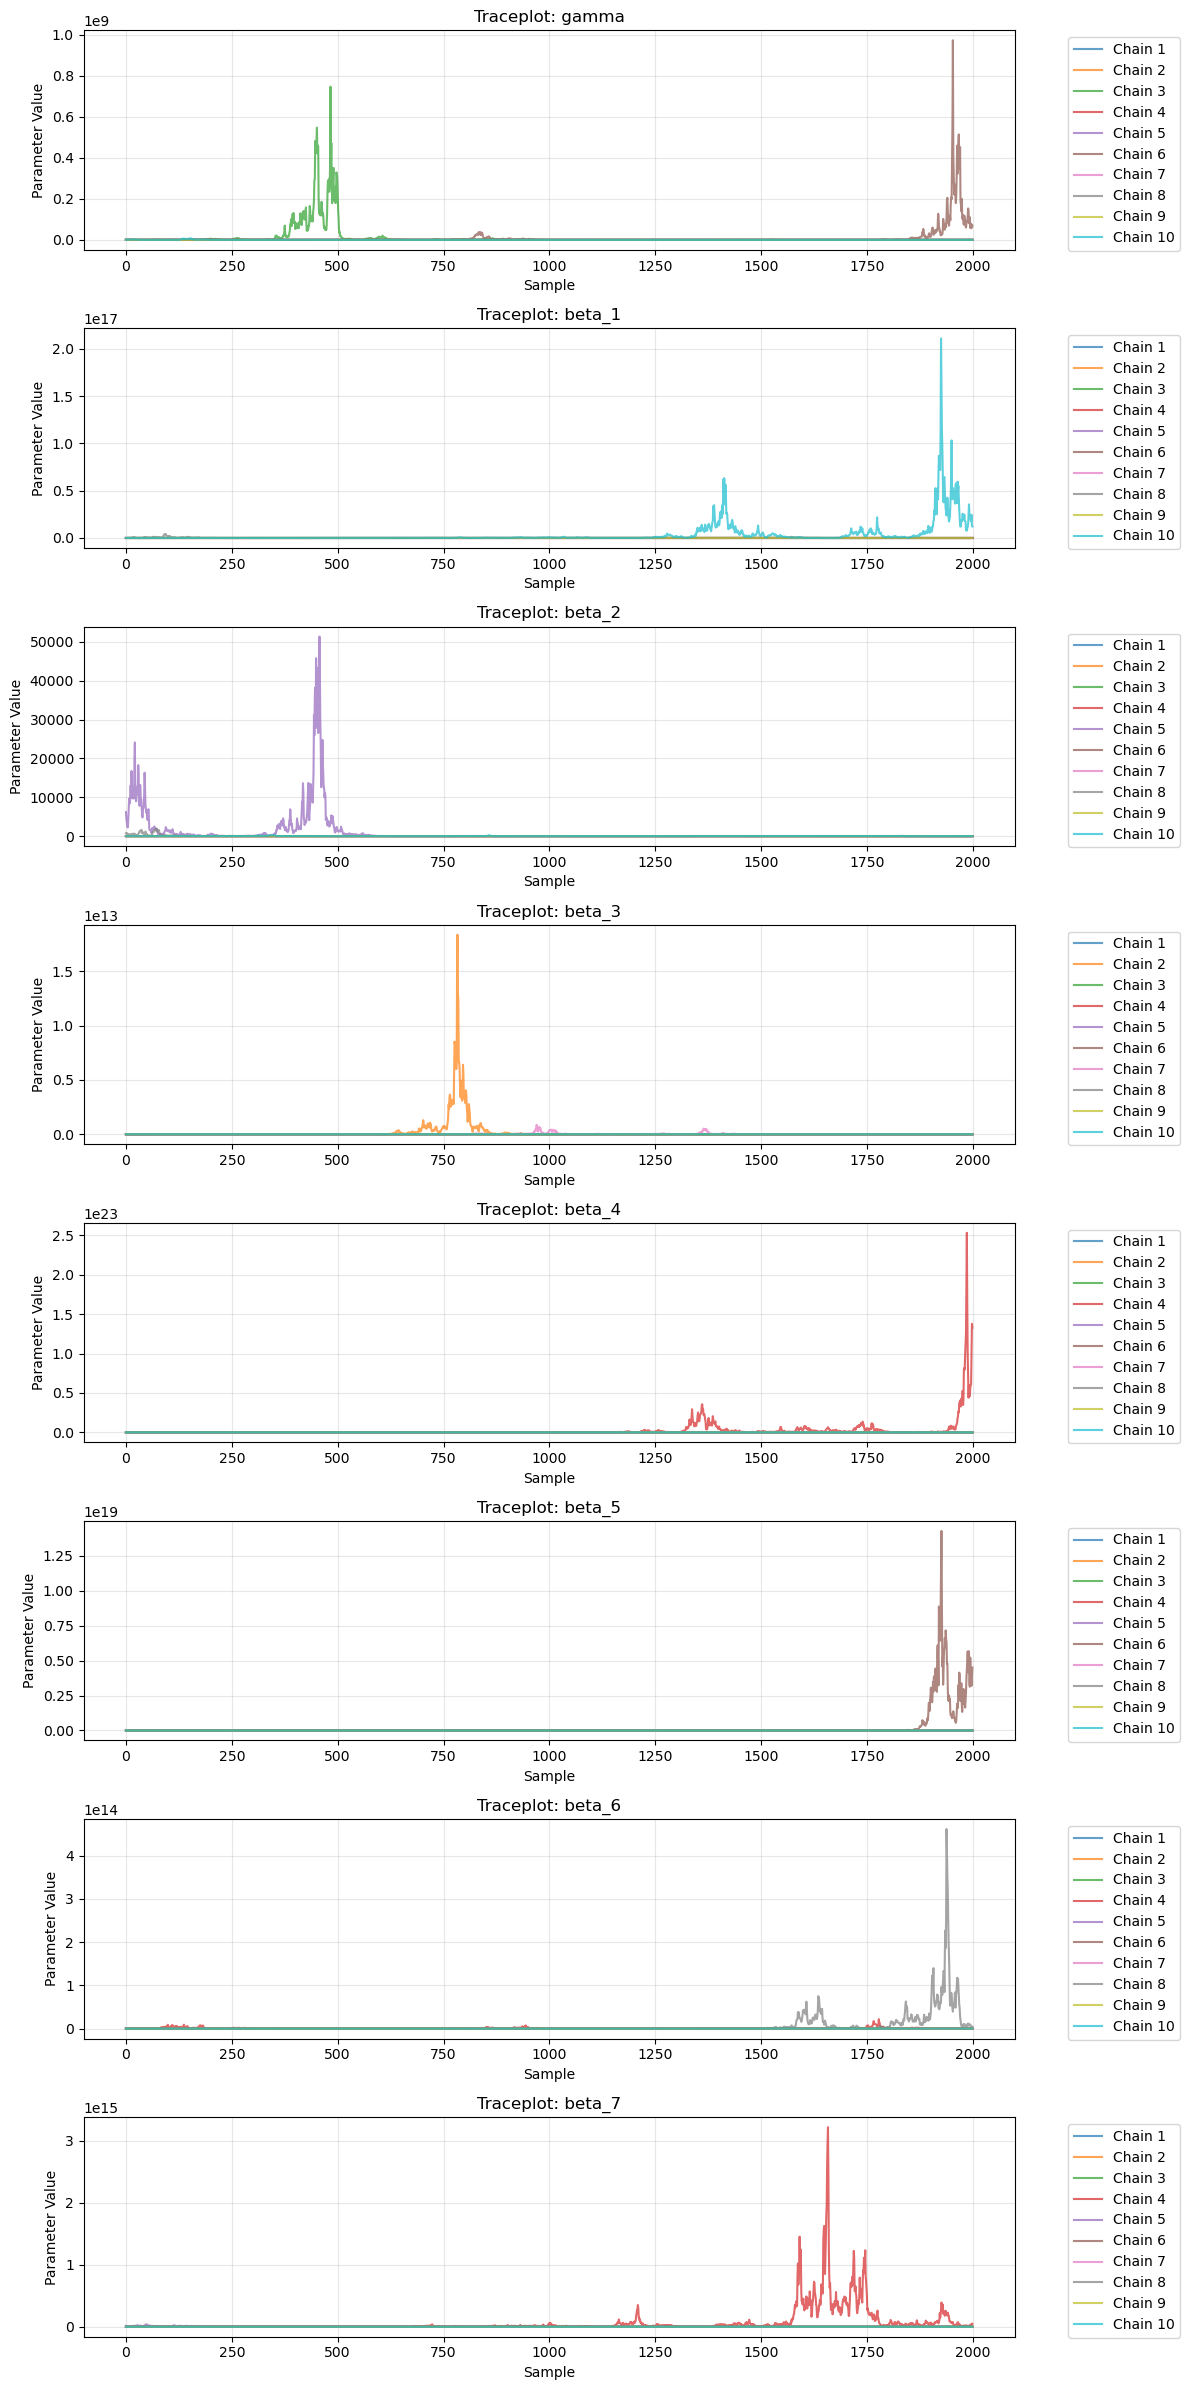


Generating posterior means plot...


/opt/miniconda3/envs/polypharm/lib/python3.13/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/miniconda3/envs/polypharm/lib/python3.13/site-packages/numpy/_core/_methods.py:205: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


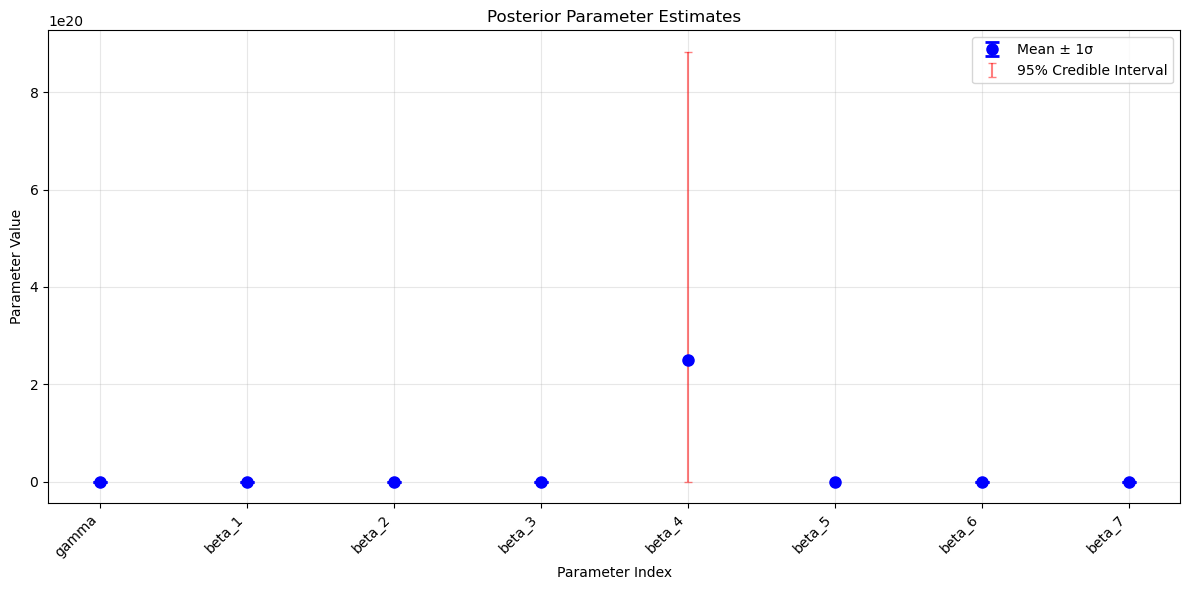


Posterior Parameter Summary:
gamma          : 1964824.0000 ± 21971388.0000
                 95% CI: [0.0000, 4088785.6187]
beta_1         : 355181917110272.0000 ± 3855544628543488.0000
                 95% CI: [0.0000, 1412235219540376.5000]
beta_2         :  99.9681 ± 1280.4497
                 95% CI: [0.0000, 250.5124]
beta_3         : 18300704768.0000 ± 302442708992.0000
                 95% CI: [0.0000, 32935778099.2000]
beta_4         : 250504707235647586304.0000 ±    inf
                 95% CI: [0.0000, 882752473472257097728.0000]
beta_5         : 19066070644031488.0000 ±    inf
                 95% CI: [0.0000, 3131728573235.1865]
beta_6         : 665834094592.0000 ± 8368453320704.0000
                 95% CI: [0.0000, 2345582251212.7754]
beta_7         : 7083191173120.0000 ± 72198358302720.0000
                 95% CI: [0.0000, 31688111213772.6055]

Generating correlation matrix...


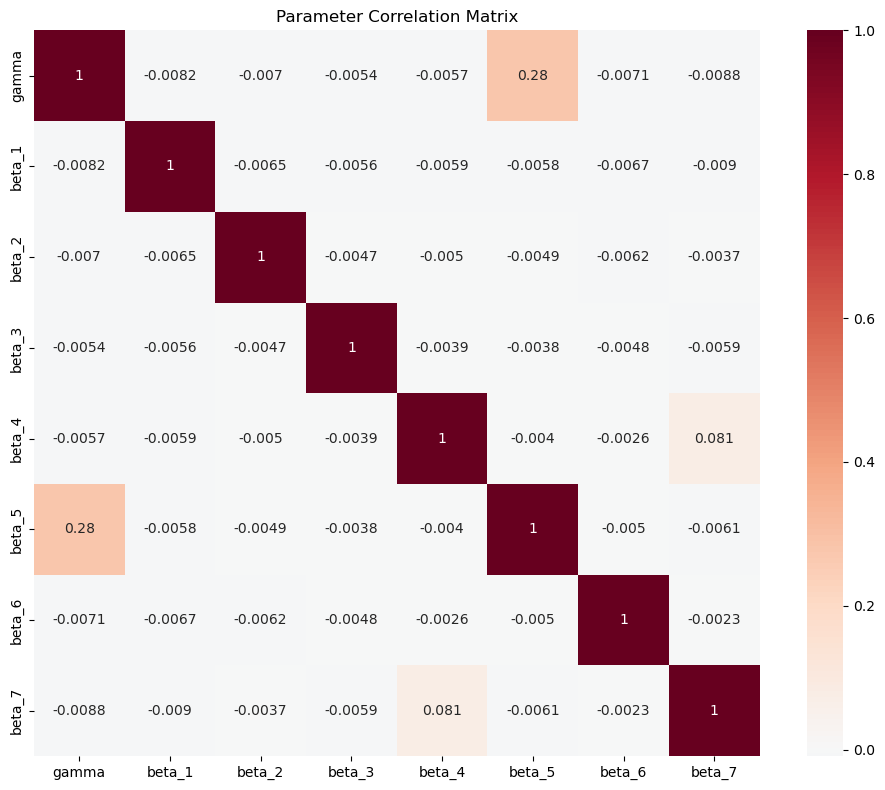


Timing Information:
Average sampling time per chain: 17.98 seconds
Total sampling time: 179.84 seconds


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

def load_posterior_samples(results_dir_pattern="./Res/ising_*"):
    """
    Load posterior samples from the most recent results directory.
    
    Args:
        results_dir_pattern (str): Pattern to match results directories
        
    Returns:
        tuple: (post_samples, times_post, beta_opt, time_bootstrap)
    """
    # Find the most recent results directory
    results_dirs = glob.glob(results_dir_pattern)
    if not results_dirs:
        raise FileNotFoundError(f"No results directories found matching pattern: {results_dir_pattern}")
    
    latest_dir = max(results_dirs, key=Path)
    print(f"Loading results from: {latest_dir}")
    
    # Load the saved arrays
    post_samples = np.load(f"{latest_dir}/post_samples.npy")
    times_post = np.load(f"{latest_dir}/times_post.npy")
    
    # Try to load bootstrap results if they exist
    beta_opt = None
    time_bootstrap = None
    try:
        beta_opt = np.load(f"{latest_dir}/beta_opt.npy")
        time_bootstrap = np.load(f"{latest_dir}/time_bootstrap.npy")
    except FileNotFoundError:
        print("Bootstrap results not found, skipping...")
    
    return post_samples, times_post, beta_opt, time_bootstrap

def plot_traceplots(post_samples, param_names=None, n_chains=10, n_samples=2000):
    """
    Create traceplots for posterior samples.
    
    Args:
        post_samples (np.ndarray): Array of shape (n_chains, n_samples, n_params)
        param_names (list): Names of parameters
        n_chains (int): Number of chains
        n_samples (int): Number of samples per chain
    """
    n_params = post_samples.shape[2]
    
    if param_names is None:
        param_names = [f"param_{i}" for i in range(n_params)]
    
    # Create subplots
    fig, axes = plt.subplots(n_params, 1, figsize=(12, 3*n_params))
    if n_params == 1:
        axes = [axes]
    
    for i, (ax, param_name) in enumerate(zip(axes, param_names)):
        # Plot each chain with different colors
        for chain in range(n_chains):
            ax.plot(post_samples[chain, :, i], alpha=0.7, label=f'Chain {chain+1}')
        
        ax.set_title(f'Traceplot: {param_name}')
        ax.set_xlabel('Sample')
        ax.set_ylabel('Parameter Value')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_posterior_means(post_samples, param_names=None):
    """
    Plot posterior means and credible intervals.
    
    Args:
        post_samples (np.ndarray): Array of shape (n_chains, n_samples, n_params)
        param_names (list): Names of parameters
    """
    n_params = post_samples.shape[2]
    
    if param_names is None:
        param_names = [f"param_{i}" for i in range(n_params)]
    
    # Calculate posterior statistics
    # Flatten across chains
    flat_samples = post_samples.reshape(-1, n_params)
    
    posterior_means = np.mean(flat_samples, axis=0)
    posterior_stds = np.std(flat_samples, axis=0)
    credible_intervals_95 = np.percentile(flat_samples, [2.5, 97.5], axis=0)
    credible_intervals_68 = np.percentile(flat_samples, [16, 84], axis=0)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x_pos = np.arange(n_params)
    
    # Plot means with error bars
    ax.errorbar(x_pos, posterior_means, yerr=posterior_stds, 
                fmt='o', capsize=5, capthick=2, markersize=8,
                label='Mean ± 1σ', color='blue')
    
    # Plot credible intervals
    ax.errorbar(x_pos, posterior_means, 
                yerr=np.abs([posterior_means - credible_intervals_95[0], 
                      credible_intervals_95[1] - posterior_means]),
                fmt='none', capsize=3, capthick=1, alpha=0.5,
                label='95% Credible Interval', color='red')
    ax.set_xlabel('Parameter Index')
    ax.set_ylabel('Parameter Value')
    ax.set_title('Posterior Parameter Estimates')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(param_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPosterior Parameter Summary:")
    print("=" * 60)
    for i, param_name in enumerate(param_names):
        print(f"{param_name:15s}: {posterior_means[i]:8.4f} ± {posterior_stds[i]:6.4f}")
        print(f"{'':15s}  95% CI: [{credible_intervals_95[0, i]:6.4f}, {credible_intervals_95[1, i]:6.4f}]")
    
    return posterior_means, posterior_stds, credible_intervals_95

def plot_parameter_correlations(post_samples, param_names=None):
    """
    Plot correlation matrix of parameters.
    
    Args:
        post_samples (np.ndarray): Array of shape (n_chains, n_samples, n_params)
        param_names (list): Names of parameters
    """
    n_params = post_samples.shape[2]
    
    if param_names is None:
        param_names = [f"param_{i}" for i in range(n_params)]
    
    # Flatten across chains
    flat_samples = post_samples.reshape(-1, n_params)
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(flat_samples.T)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                xticklabels=param_names, yticklabels=param_names,
                square=True, ax=ax)
    ax.set_title('Parameter Correlation Matrix')
    plt.tight_layout()
    plt.show()

# Load the posterior samples
try:
    post_samples, times_post, beta_opt, time_bootstrap = load_posterior_samples()
    
    print(f"Loaded posterior samples shape: {post_samples.shape}")
    print(f"Number of chains: {post_samples.shape[0]}")
    print(f"Number of samples per chain: {post_samples.shape[1]}")
    print(f"Number of parameters: {post_samples.shape[2]}")
    
    # Create parameter names based on Ising model structure
    # First parameter is gamma (horizontal), rest are beta parameters (vertical)
    n_params = post_samples.shape[2]
    param_names = ['gamma'] + [f'beta_{i}' for i in range(1, n_params)]
    
    # Plot traceplots
    print("\nGenerating traceplots...")
    plot_traceplots(post_samples, param_names)
    
    # Plot posterior means and credible intervals
    print("\nGenerating posterior means plot...")
    posterior_means, posterior_stds, credible_intervals = plot_posterior_means(post_samples, param_names)
    
    # Plot parameter correlations
    print("\nGenerating correlation matrix...")
    plot_parameter_correlations(post_samples, param_names)
    
    # Print timing information
    print(f"\nTiming Information:")
    print(f"Average sampling time per chain: {np.mean(times_post):.2f} seconds")
    print(f"Total sampling time: {np.sum(times_post):.2f} seconds")
    
    if beta_opt is not None:
        print(f"Optimal beta: {beta_opt:.4f}")
        print(f"Bootstrap time: {time_bootstrap:.2f} seconds")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please run the model first using run_model.py to generate posterior samples.")
except Exception as e:
    print(f"Error loading or plotting results: {e}")


In [ ]:
# Here get the fitted values based on the posterior means

# Assume posterior_means is already computed (from previous cell)
# We want to compute the fitted probabilities for each patient and condition
# using the IsingAnisotropic model parameterized by the posterior means.


# Import IsingAnisotropic if not already imported
import sys
import os
sys.path.append('./Source')

try:
    from Models import IsingAnisotropic
except ImportError:
    # If not available, raise a clear error
    raise ImportError("IsingAnisotropic model not found. Please ensure Models.py is available.")

# Load the data matrix (A) and covariates (X_cov) and condition_list
# We'll try to load the same data as used for inference
try:
    from dataloader import load_data
    A, X_cov, condition_list = load_data(batch_size=1000)
    print(A.shape)
except Exception as e:
    print(f"Error loading data for fitted values: {e}")
    A = None
    X_cov = None
    condition_list = None

# Use the first timepoint if A is 3D

if A is not None:
    if A.ndim == 3:
        y_matrix = np.array(A[:, :, 0])
    else:
        y_matrix = np.array(A)
else:
    y_matrix = None

# Compute fitted probabilities using IsingAnisotropic model
fitted_prob_matrix = None
if X_cov is not None and condition_list is not None and posterior_means is not None:
    # Prepare the model
    n_patients = X_cov.shape[0]
    n_conditions = len(condition_list)
    # The IsingAnisotropic model expects n, C
    ising_model = IsingAnisotropic(n_patients, n_conditions)
    # The posterior_means should be a vector of length (C+1): [gamma, beta_1, ..., beta_C]
    # The model's .prob_matrix method expects parameters in exp() form
    params = np.exp(np.array(posterior_means))
    # Compute the probability matrix: shape (n_patients, n_conditions)
    fitted_prob_matrix = ising_model.prob_matrix(params)
else:
    print("Could not compute fitted probabilities: missing data or posterior means.")


: 

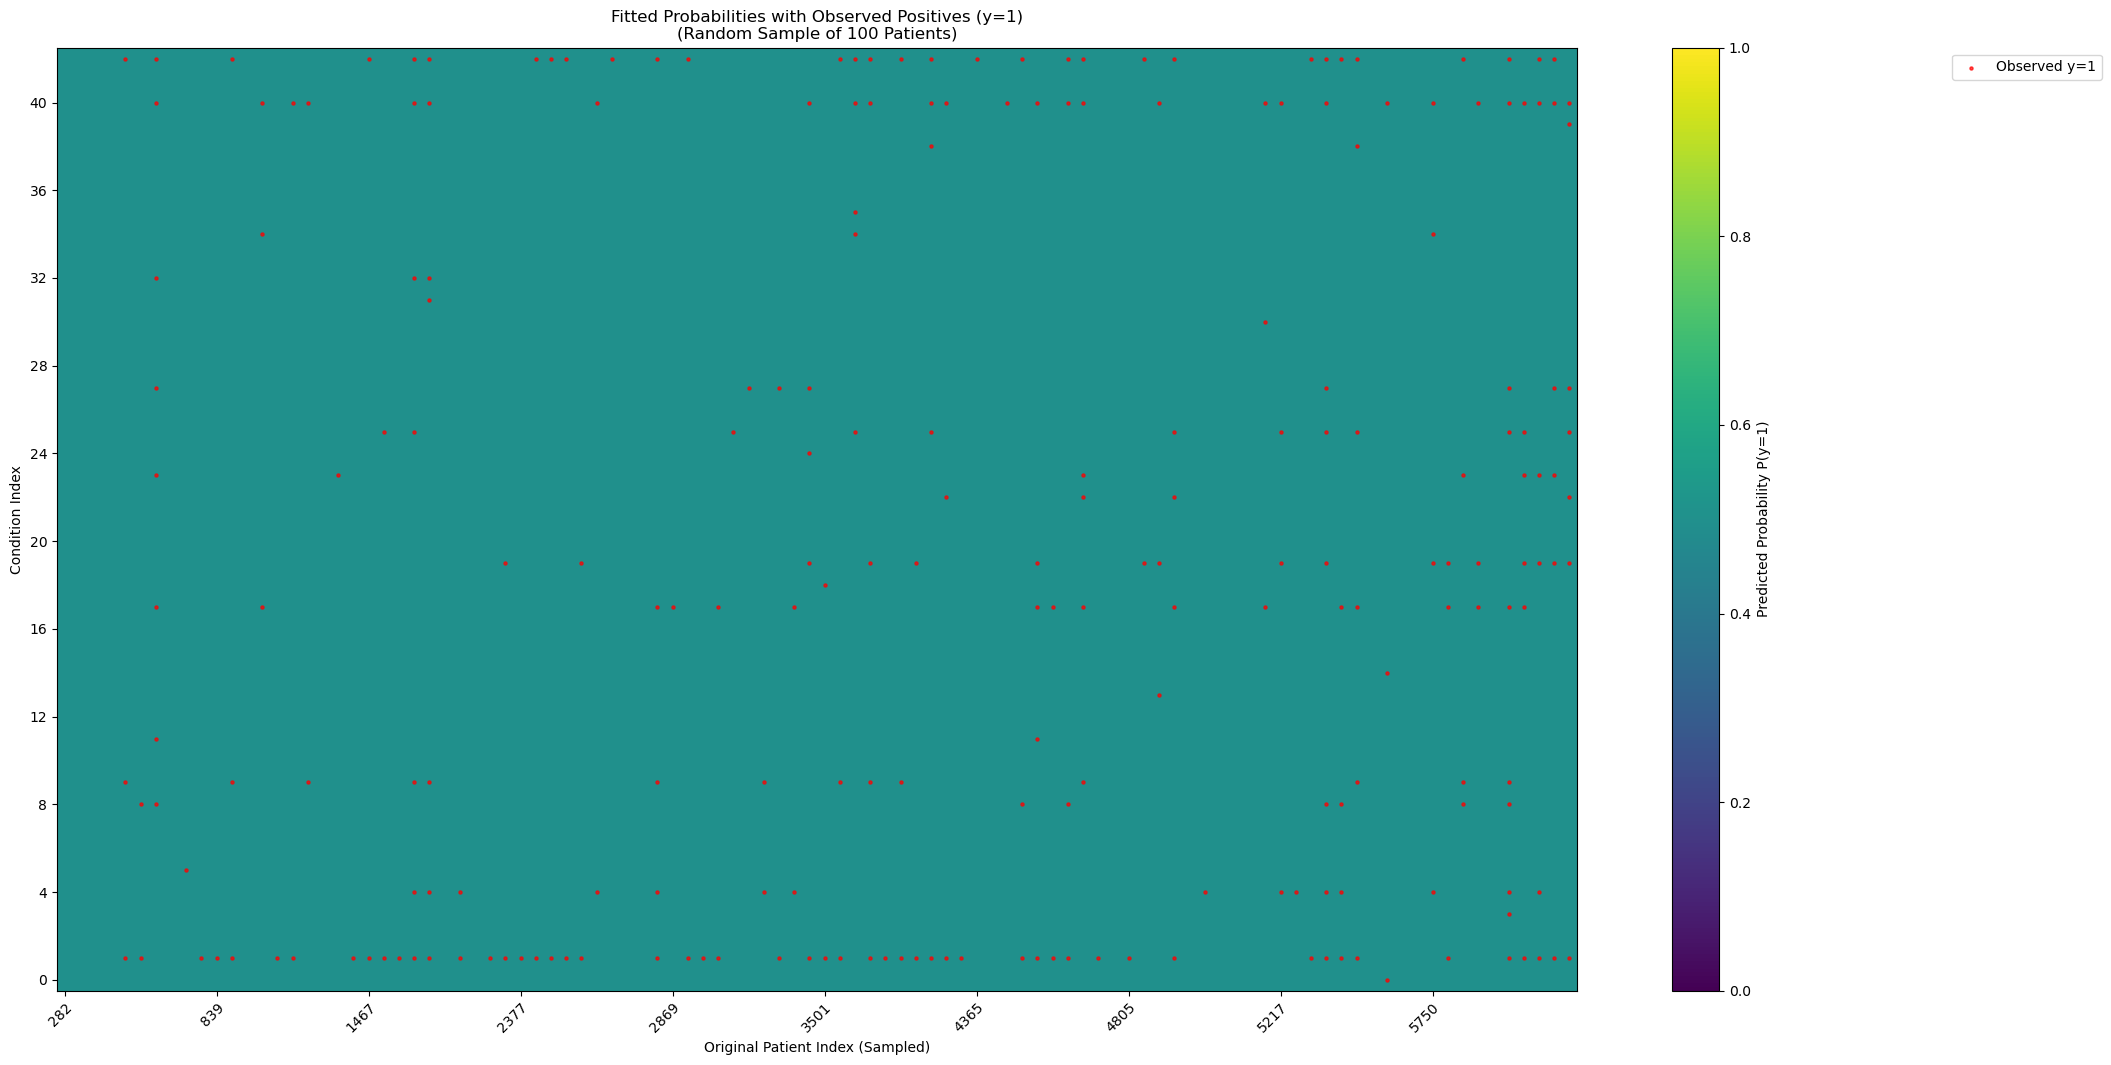

In [9]:
import matplotlib.pyplot as plt

def plot_fitted_probabilities(fitted_prob_matrix, y_matrix=None,
                               title="Predicted Probabilities Heatmap",
                               max_patients_display=100, # Max patients to display
                               random_seed=None): # Optional seed for reproducibility
    """
    Generates a heatmap of fitted probabilities, potentially sampling patients,
    with observed positives marked.

    Args:
        fitted_prob_matrix (np.ndarray | jnp.ndarray): 2D array (n_conditions, n_patients)
                                                      of predicted probabilities P(y=1).
        y_matrix (np.ndarray | jnp.ndarray): Optional 2D array (n_conditions, n_patients)
                                             of observed binary outcomes {0, 1}.
        title (str): The title for the plot.
        max_patients_display (int | None): Max number of patients to display.
                                           If None or >= n_patients, display all.
                                           Defaults to 100.
        random_seed (int | None): Optional random seed for patient sampling.
    """
    # Ensure inputs are NumPy arrays
    prob_matrix_np = np.array(fitted_prob_matrix)

    if prob_matrix_np.ndim != 2:
        logging.error(f"Input probability matrix must be 2D, but got shape {prob_matrix_np.shape}")
        return None, None

    n_conditions, n_patients = prob_matrix_np.shape
    y_matrix_np = np.array(y_matrix) if y_matrix is not None else None # Convert y_matrix if provided

    # --- Patient Sampling Logic ---
    patient_indices_to_plot = np.arange(n_patients) # Default: all patients
    plot_title = title
    sampled = False

    if max_patients_display is not None and n_patients > max_patients_display:
        logging.info(f"Sampling {max_patients_display} out of {n_patients} patients for display.")
        sampled = True
        rng = np.random.default_rng(random_seed) # Use modern RNG with optional seed
        patient_indices_to_plot = rng.choice(n_patients, max_patients_display, replace=False)
        # Sort indices to keep the plot somewhat ordered by original patient index
        patient_indices_to_plot = np.sort(patient_indices_to_plot)
        plot_title = f"{title}\n(Random Sample of {max_patients_display} Patients)"
    # --- End Sampling Logic ---

    # Subset the data according to sampled indices
    prob_matrix_to_plot = prob_matrix_np[:, patient_indices_to_plot]
    y_matrix_to_plot = y_matrix_np[:, patient_indices_to_plot] if y_matrix_np is not None else None
    n_patients_displayed = prob_matrix_to_plot.shape[1]

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(max(6, n_patients_displayed / 4), max(5, n_conditions / 4)))

    im = ax.imshow(prob_matrix_to_plot, cmap='viridis', origin='lower',
                   interpolation='nearest', vmin=0, vmax=1, aspect='auto')

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Predicted Probability P(y=1)')

    # Overlay dots if observed data is available and valid for the subset
    if y_matrix_to_plot is not None:
         if prob_matrix_to_plot.shape == y_matrix_to_plot.shape:
             # Find coordinates relative to the *subsetted* matrix
             observed_positive_conds, observed_positive_patients_idx = np.where(y_matrix_to_plot == 1)
             # Scatter uses the index within the displayed plot (0 to n_patients_displayed-1) for x
             ax.scatter(observed_positive_patients_idx, observed_positive_conds,
                        marker='.', color='red', s=20, label='Observed y=1', alpha=0.7) # Slightly larger dots
             ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
         else:
             logging.warning("Shape mismatch between sampled probabilities and sampled outcomes. Cannot overlay markers.")

    # --- Configure Axes ---
    ax.set_xlabel("Original Patient Index (Sampled)") if sampled else ax.set_xlabel("Patient Index")
    ax.set_ylabel("Condition Index")
    ax.set_title(plot_title)

    # --- X-axis Ticks ---
    # Label ticks with the *original* patient indices that were sampled
    if n_patients_displayed <= 40: # Show all labels if few enough points displayed
        ax.set_xticks(np.arange(n_patients_displayed))
        ax.set_xticklabels(patient_indices_to_plot) # Use original indices as labels
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    else: # Use fewer ticks for large number of displayed patients
        step = max(1, n_patients_displayed // 10)
        tick_positions = np.arange(0, n_patients_displayed, step)
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(patient_indices_to_plot[tick_positions]) # Label with corresponding original indices
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # --- Y-axis Ticks ---
    if n_conditions <= 40:
         ax.set_yticks(np.arange(n_conditions))
         ax.set_yticklabels(np.arange(n_conditions))
    else:
        step = max(1, n_conditions // 10)
        tick_positions = np.arange(0, n_conditions, step)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_positions)


    fig.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout rect to make space for legend

    return fig, ax

# %% Optional: Visualize Results (Using Modified Plot Function)

logging.info("\nAttempting to reshape predictions and visualize (sampled)...")
# Reshape the flat predictions back into the (n_conditions, n_patients) grid
try:
    if 'n_conditions' not in locals() or 'n_patients' not in locals():
         raise NameError("Variables n_conditions or n_patients not defined.")
    if 'predicted_probabilities' not in locals():
        raise NameError("Variable predicted_probabilities not defined.")
    if 'y_matrix' not in locals():
        raise NameError("Variable y_matrix (observed outcomes) not defined.")


    pred_prob_matrix = predicted_probabilities.reshape((n_conditions, n_patients))
    logging.info(f"Reshaped predictions to matrix: {pred_prob_matrix.shape}")

    logging.info("Generating probability heatmap plot (sampling max 100 patients)...")
    # Call the modified plotting function
    fig, ax = plot_fitted_probabilities(
        pred_prob_matrix,
        y_matrix, # Pass observed outcomes to mark dots
        title="Fitted Probabilities with Observed Positives (y=1)",
        max_patients_display=100, # Set the limit here
        random_seed=42 # Optional: for reproducible sampling
    )

    if fig is not None:
        # Save the plot automatically
        plot_filename = f'fitted_probs_heatmap_sampled_{saved_model_path.stem}.png' # Add sampled to name
        try:
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            logging.info(f"Saved sampled plot to {plot_filename}")
        except Exception as e_save:
            logging.error(f"Failed to save plot: {e_save}")

        # Display the plot in the notebook
        plt.show()
    else:
        logging.error("Plot generation failed.")

except NameError as e_reshape:
    logging.warning(f"Could not reshape/plot - required variables not found: {e_reshape}")
except ValueError as e_shape:
    logging.error(f"Error reshaping/plotting: {e_shape}")
except Exception as e_plot:
      logging.error(f"An error occurred during plotting: {e_plot}", exc_info=True)